# <center> Are Haters Just Hating? A Statistical Analysis of CSGO Pro Gamers
<center> Sam Felsenfeld, Cindy Jia, Mark Levin </center>

## <center> Introduction</center>

Public opinion can often be a misrepresentation of the actual performance of public figures. In this analysis, we explore the case of CSGO e-sports athletes, and determine whether the public perception that a player is either at the top of their game or on their way out actually correlated with their typical performance, or more likely influenced by a single event.

## <center> Data Collection


In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import requests
from bs4 import BeautifulSoup
import re
from requests_html import AsyncHTMLSession

In [3]:
### Create a list of world rankings
url = "https://pro.eslgaming.com/worldranking/csgo/rankingshistory/"

### Get page and render javascript
session = AsyncHTMLSession()
r = await session.get(url)
await r.html.arender()


### Start scraping page (not finished)
bs = BeautifulSoup(r.html.html)
for el in bs.find_all("div", class_="small"):
    print(el)

In [4]:
### Get a list of AWPers from liquipedia
### Getting AWPers
urls = ["https://liquipedia.net/counterstrike/Category:AWPers",
        "https://liquipedia.net/counterstrike/index.php?title=Category:AWPers&pagefrom=Galantis#mw-pages",
        "https://liquipedia.net/counterstrike/index.php?title=Category:AWPers&pagefrom=Powell#mw-pages"]

awpers = {"~~~~"} # Create a lookup table of AWPers
for url in urls:
    res = requests.get(url)
    bs = BeautifulSoup(res.content)
    ### Toggle system to only get from first to last player on each page
    toggle = False
    for l in bs.find_all("a"):
        if "Ace" in l.get('href') or "/Galantis" in l.get('href') or "/Powell" in l.get('href'):
            toggle=True
        if toggle:
            s = l.get('href')[15:].lower()
            awpers.add(s) # Add base name
            if "_" in s:
                s = s[:s.find("_")] # add name with extra annotations removed
            awpers.add(s)
            s = re.sub(r'[^a-zA-Z0-9]', '', s)# Remove extra characters
            awpers.add(s)
        if "Gafolo" in l.get('href') or "Potei" in l.get('href') or "ZywOo" in l.get('href'):
            toggle=False

with open("AWPers.json", 'w') as file:
    json.dump(list(awpers), file)

## <center> Data Processing

After we've collected a list of AWPers we can then add a column to our dataframe to indicate whether a player is an AWPer or not. We also remove columns that do not provide useful information.

In [5]:
df = pd.read_csv("all games processed.csv", sep=',')
with open('AWPers.json') as file:
    awpers = json.load(file)
df= df.drop('Unnamed: 0', axis=1)

# cleaning data and labeling AWPers
df['rating'] = df['rating'].apply(lambda s: float(s.replace("*", "")))
df['Awper'] = df['player name'].apply(lambda s: s in awpers)
df.head()

,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper
0,31/10/20,Golden Knights,Lyngby Vikings,nuke,17 - 21,-4,0.83,fitch,0.809524,13,16,29,False
1,31/10/20,Golden Knights,Lyngby Vikings,mrg,14 - 20,-6,0.77,fitch,0.700000,16,12,28,False
2,19/5/20,Syman,SG.pro,trn,8 - 20,-12,0.56,fitch,0.400000,13,16,29,False
3,19/5/20,Syman,SG.pro,mrg,11 - 18,-7,0.61,fitch,0.611111,10,16,26,False
4,18/5/20,Syman,LDLC,d2,13 - 19,-6,0.87,fitch,0.684211,11,16,27,False


The dates are converted to datetime objects so the data points can be compared effectively. To learn more about the Python datetime module, click [here](https://docs.python.org/3/library/datetime.html).

In [6]:
df = df.assign(Date = pd.to_datetime(df['Date']))
df.sort_values('Date').head()

,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper
380533,2012-01-11,dotpiXels,CPLAY,mrg,15 - 16,-1,0.87,legija,0.937500,16,6,22,False
474590,2012-01-11,gamed!de,iPLAY,trn,22 - 12,10,1.47,syrson,1.833333,16,7,23,True
469648,2012-01-11,ALTERNATE aTTaX,CPLAY,trn,15 - 12,3,0.96,krystal,1.250000,16,9,25,False
438636,2012-01-11,dotpiXels,CPLAY,mrg,32 - 13,19,2.19,tabsen,2.461538,16,6,22,False
485888,2012-01-12,BuyKey,ESC,inf,26 - 16,10,1.57,scream,1.625000,16,7,23,False


If we want to make useful comparisons between data points at different points in time, then we need to standardize the data across time. Since AWPers are a subset of all players who tend to have a higher rating due to their position, we will also standardize across role. To learn more about how data standardization works and why it's important, click [here](https://machinelearningcompass.com/dataset_optimization/standardization/).

In [11]:
x = np.arange(2012, 2024)
y = []
y_awp = []
y_rifle = []

# determining mean performance per year and standardizing rating
for year in x:
    date_mask = (dt.datetime(year,1,1) < df['Date']) & (df['Date'] < dt.datetime(year,12,31))
    y.append(df[date_mask]['rating'].mean())
    mean_awp = df[date_mask & df['Awper']]['rating'].mean()
    y_awp.append(mean_awp)
    mean_rifle = df[date_mask & ~df['Awper']]['rating'].mean()
    y_rifle.append(mean_rifle)

    std_awp = df[date_mask & df['Awper']]['rating'].std()
    std_rifle = df[date_mask & ~df['Awper']]['rating'].std()
    
    df.loc[date_mask & df['Awper'],'standard rating'] = (df['rating']-mean_awp) / std_awp
    df.loc[date_mask & ~df['Awper'],'standard rating'] = (df['rating']-mean_rifle) / std_rifle

df.head()

,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper,standard rating
380533,2012-01-11,dotpiXels,CPLAY,mrg,15 - 16,-1,0.87,legija,0.937500,16,6,22,False,-0.618986
474590,2012-01-11,gamed!de,iPLAY,trn,22 - 12,10,1.47,syrson,1.833333,16,7,23,True,0.864893
469648,2012-01-11,ALTERNATE aTTaX,CPLAY,trn,15 - 12,3,0.96,krystal,1.250000,16,9,25,False,-0.387562
438636,2012-01-11,dotpiXels,CPLAY,mrg,32 - 13,19,2.19,tabsen,2.461538,16,6,22,False,2.775235
485888,2012-01-12,BuyKey,ESC,inf,26 - 16,10,1.57,scream,1.625000,16,7,23,False,1.180980


## <center> Data Visualization

Plotting the average yearly rating for all pro players, AWPers only, and riflers only, is very important to understand the importance of data standardization. If we are to compare the performance of players across years, then comparing their nominal rating is not a good way to accurately assess whether one player is better than another. From this plot we can also see the disparity in average rating between AWP and rifle users, so there is clearly a need to standardize across not only time but also the weapon used if we want to compare players regardless of weapon choice.

Text(0.5, 1.0, 'Average yearly rating')

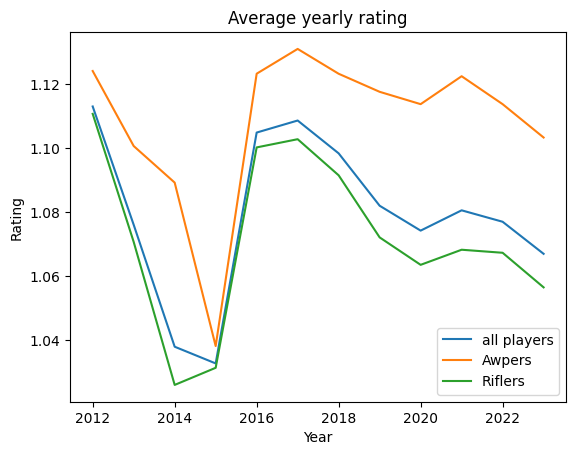

In [13]:
plt.plot(x,y,label = 'all players')
plt.plot(x,y_awp,label = 'AWPers')
plt.plot(x,y_rifle,label = 'Riflers')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Rating")
plt.title("Average yearly rating")

We elected to do an analysis on a select sample of pro players with varying public opinions on their performances. zywoo and ax1le are considered to be very strong players currently, karrigan and gla1ve are in game leaders (igls) which means they have relatively poor rating but are important to the game objectives, teses and perfecto are considered to be average players, and s1mple and cerq are players who may be past their peak performance.

Text(0.5, 1.0, 'Average yearly rating')

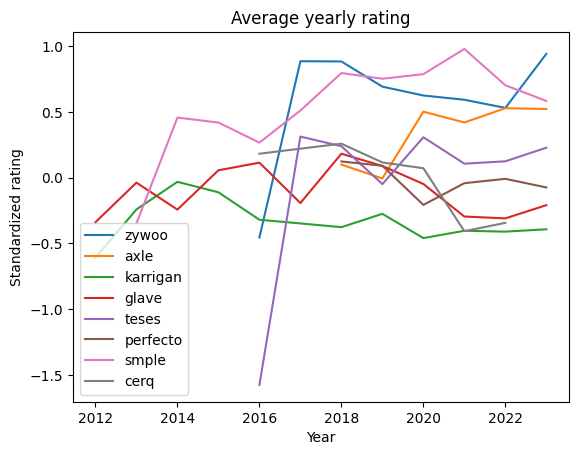

In [9]:
notable_players = ['zywoo','axle','karrigan','glave','teses','perfecto','smple','cerq']
df = df.sort_values('Date')

for i in range(len(notable_players)):
    y = []
    for year in x:
        date_mask = (dt.datetime(year,1,1) < df['Date']) & (df['Date'] < dt.datetime(year,12,31))
        y.append(df[date_mask & (df['player name'] == notable_players[i])]['standard rating'].mean())
        
    plt.plot(x, y, label = notable_players[i])

plt.legend()
plt.xlabel("Year")
plt.ylabel("Standardized rating")
plt.title("Average yearly rating")

From an initial visual analysis of the plot, it's clear that from this sample of pro CSGO players that public opinion is fairly accurate. zywoo and axle are among the top players, but while cerq is indeed past his peak, s1mple is still a top performer. However if we want to do a more rigorous analysis of each player's performance, then we need to some regression analysis.